In [1]:
import os
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader

from sklearn.metrics import RocCurveDisplay, confusion_matrix, roc_auc_score, precision_recall_curve

import matplotlib.pyplot as plt
%matplotlib inline

from libs.datasets import val_transform, CancerDataset
from libs.efficientnet import EffNetModel, ModelEma
from libs.utils import set_seed, val_one_batch, plot_confusion_matrix

os.environ["CUDA_VISIBLE_DEVICES"] = '1,2'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
best_weights_vloss, best_weights_auc = [], []
for i in range(4):
    min_vloss, best_weight_vloss = 10000.0, "vloss"
    max_auc, best_weight_auc = 0.5, "auc"
    for weight in glob.glob(f"ckpt/f{i}/*.pth"):
        if float(weight.split("_")[-1][:-4]) < min_vloss:
            min_vloss = float(weight.split("_")[-1][:-4])
            best_weight_vloss = weight
        if float(weight.split("_")[-3]) > max_auc:
            max_auc = float(weight.split("_")[-3])
            best_weight_auc = weight

    best_weights_vloss.append(best_weight_vloss)
    best_weights_auc.append(best_weight_auc)

print(best_weights_vloss)
print(best_weights_auc)

['ckpt/f0/f0_ep40_roc_0.782_loss_0.231.pth', 'ckpt/f1/f1_ep63_roc_0.915_loss_0.193.pth', 'ckpt/f2/f2_ep68_roc_0.917_loss_0.170.pth', 'ckpt/f3/f3_ep61_roc_0.923_loss_0.180.pth']
['ckpt/f0/f0_ep53_roc_0.792_loss_0.256.pth', 'ckpt/f1/f1_ep63_roc_0.915_loss_0.193.pth', 'ckpt/f2/f2_ep62_roc_0.926_loss_0.176.pth', 'ckpt/f3/f3_ep61_roc_0.923_loss_0.180.pth']


In [3]:
final_targets, final_outputs = [], []

for i in range(4):
    val_loss = 0
    val_targets, val_outputs = [], []

    val_df = pd.read_pickle(f"./df/val_f{i}.pkl")
    val_dataset = CancerDataset(val_df, transform=val_transform)
    val_dataloader = DataLoader(val_dataset, batch_size=40, num_workers=4, shuffle=False)

    criterion = nn.BCELoss(reduction="mean")

    model = EffNetModel()
    model.to(DEVICE)
    checkpoint = torch.load(best_weights_auc[i], map_location=torch.device('cuda:0'))
    model.load_state_dict(checkpoint['state_dict_ema'])
    model.eval()
    for batch in tqdm(val_dataloader):
        with torch.no_grad():
            loss, y_true, y_pred = val_one_batch(batch, model, criterion, DEVICE)
            val_loss += loss
            val_targets.extend(y_true)
            val_outputs.extend(y_pred)

    final_targets.extend(val_targets)
    final_outputs.extend(val_outputs)

del checkpoint, model

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [02:09<00:00,  1.64s/it]


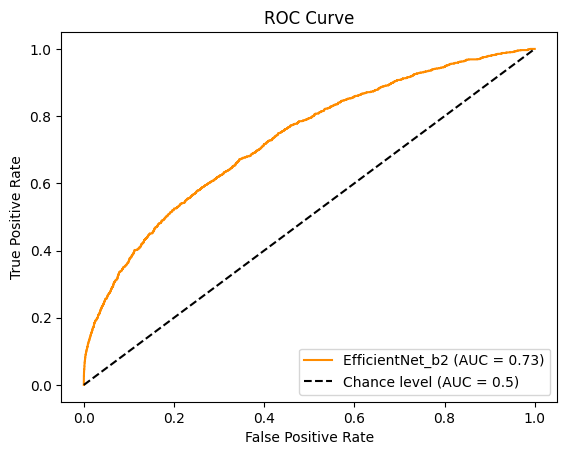

In [4]:
display = RocCurveDisplay.from_predictions(
    final_targets,
    final_outputs,
    name="EfficientNet_b2",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC Curve",
)
plt.savefig("./output/roc_curve.png")

In [5]:
precision, recall, thresholds = precision_recall_curve(final_targets, final_outputs)

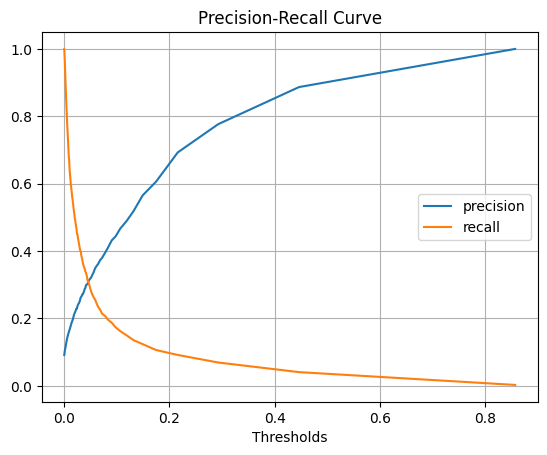

In [11]:
#create precision recall curve
fig, ax = plt.subplots()
ax.plot(thresholds[::50], precision[::50], label="precision")
ax.plot(thresholds[::50], recall[::50], label="recall")
ax.legend()
plt.grid()

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
#ax.set_ylabel('Precision')
ax.set_xlabel('Thresholds')

#display plot
plt.show()

In [7]:
# sensitivity and specificity curves
senss, specs = [], []
for thresh in thresholds[::50]:
    final_outputs_binary = [1.0 if fo > thresh else 0.0 for fo in final_outputs]
    tn, fp, fn, tp = confusion_matrix(final_targets, final_outputs_binary).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    senss.append(sensitivity)
    specs.append(specificity)

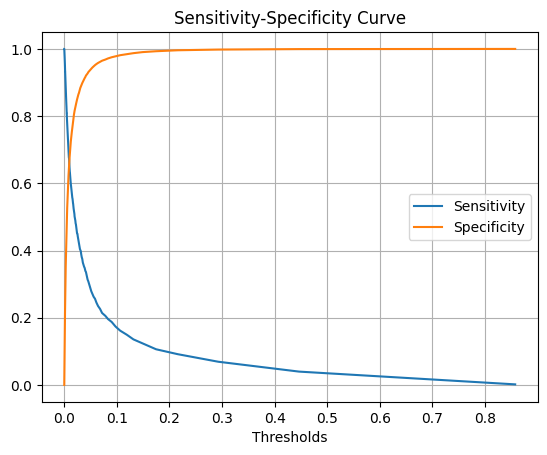

In [13]:
fig, ax = plt.subplots()
ax.plot(thresholds[::50], senss, label="Sensitivity")
ax.plot(thresholds[::50], specs, label="Specificity")
ax.legend()
plt.grid()

#add axis labels to plot
ax.set_title('Sensitivity-Specificity Curve')
#ax.set_ylabel('Precision')
ax.set_xlabel('Thresholds')
plt.xticks(np.arange(0, 0.9, 0.1))

#display plot
plt.show()

In [36]:
thresh = 0
min_diff = 1000000
for i in range(len(senss)):
    if abs(senss[i]-specs[i]) < min_diff:
         thresh = thresholds[::50][i]
         min_diff = abs(senss[i]-specs[i])

print(thresh)

0.009564890526235104


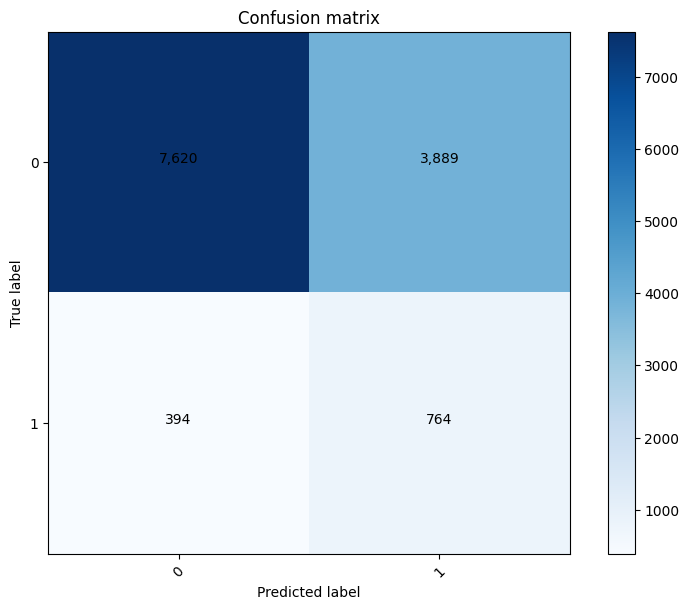

In [38]:
final_outputs_binary = [1.0 if fo > thresh else 0.0 for fo in final_outputs]
cm = confusion_matrix(final_targets, final_outputs_binary)

plot_confusion_matrix(cm, target_names=[0, 1], title='Confusion matrix', cmap=None, normalize=False)

In [23]:
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity: ", f"{sensitivity:.4f}", "Specificity: ", f"{specificity:.4f}")

Sensitivity:  0.0017 Specificity:  1.0000
